In [244]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import xgboost as xgb
from pandas import read_csv
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, BaggingClassifier, \
    AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
%matplotlib inline

In [256]:
train = pd.read_csv('../input/train.csv',parse_dates=['timestamp'])


In [257]:
train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [260]:
test = pd.read_csv('../input/test.csv', parse_dates=['timestamp'])
id_test = test.id

In [261]:
test.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
0,30474,2015-07-01,39.0,20.7,2,9,1,1998.0,1,8.9,...,8,0,0,0,1,10,1,0,14,1
1,30475,2015-07-01,79.2,NaN,8,17,1,0.0,3,1.0,...,4,1,1,0,2,11,0,1,12,1
2,30476,2015-07-01,40.5,25.1,3,5,2,1960.0,2,4.8,...,42,11,4,0,10,21,0,10,71,11
3,30477,2015-07-01,62.8,36.0,17,17,1,2016.0,2,62.8,...,1,1,2,0,0,10,0,0,2,0
4,30478,2015-07-01,40.0,40.0,17,17,1,0.0,1,1.0,...,5,1,1,0,2,12,0,1,11,1


In [262]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
hospital_beds_raion,14441,0.473926
build_year,13605,0.446490
state,13559,0.444980
cafe_avg_price_500,13281,0.435857
cafe_sum_500_max_price_avg,13281,0.435857
cafe_sum_500_min_price_avg,13281,0.435857
max_floor,9572,0.314135
material,9572,0.314135
num_room,9572,0.314135
kitch_sq,9572,0.314135


In [263]:
train.shape

(30471, 292)

In [264]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 292 entries, id to price_doc
dtypes: datetime64[ns](1), float64(119), int64(157), object(15)
memory usage: 67.9+ MB


In [265]:
train.describe()

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
count,30471.000000,30471.000000,24088.000000,30304.000000,20899.000000,20899.000000,1.686600e+04,20899.000000,20899.000000,16912.000000,...,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,3.047100e+04
mean,15237.917397,54.214269,34.403271,7.670803,12.558974,1.827121,3.068057e+03,1.909804,6.399301,2.107025,...,32.058318,10.783860,1.771783,15.045552,30.251518,0.442421,8.648814,52.796593,5.987070,7.123035e+06
std,8796.501536,38.031487,52.285733,5.319989,6.756550,1.481154,1.543878e+05,0.851805,28.265979,0.880148,...,73.465611,28.385679,5.418807,29.118668,47.347938,0.609269,20.580741,46.292660,4.889219,4.780111e+06
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+05
25%,7620.500000,38.000000,20.000000,3.000000,9.000000,1.000000,1.967000e+03,1.000000,1.000000,1.000000,...,2.000000,1.000000,0.000000,2.000000,9.000000,0.000000,0.000000,11.000000,1.000000,4.740002e+06
50%,15238.000000,49.000000,30.000000,6.500000,12.000000,1.000000,1.979000e+03,2.000000,6.000000,2.000000,...,8.000000,2.000000,0.000000,7.000000,16.000000,0.000000,2.000000,48.000000,5.000000,6.274411e+06
75%,22855.500000,63.000000,43.000000,11.000000,17.000000,2.000000,2.005000e+03,2.000000,9.000000,3.000000,...,21.000000,5.000000,1.000000,12.000000,28.000000,1.000000,7.000000,76.000000,10.000000,8.300000e+06
max,30473.000000,5326.000000,7478.000000,77.000000,117.000000,6.000000,2.005201e+07,19.000000,2014.000000,33.000000,...,377.000000,147.000000,30.000000,151.000000,250.000000,2.000000,106.000000,218.000000,21.000000,1.111111e+08


In [266]:
train.dtypes

id                                                int64
timestamp                                datetime64[ns]
full_sq                                           int64
life_sq                                         float64
floor                                           float64
max_floor                                       float64
material                                        float64
build_year                                      float64
num_room                                        float64
kitch_sq                                        float64
state                                           float64
product_type                                     object
sub_area                                         object
area_m                                          float64
raion_popul                                       int64
green_zone_part                                 float64
indust_part                                     float64
children_preschool                              

In [267]:
missing_val = train.isnull().sum()
missing_val.sort_values(ascending=False).head(50)

hospital_beds_raion                      14441
build_year                               13605
state                                    13559
cafe_avg_price_500                       13281
cafe_sum_500_max_price_avg               13281
cafe_sum_500_min_price_avg               13281
max_floor                                 9572
material                                  9572
num_room                                  9572
kitch_sq                                  9572
preschool_quota                           6688
school_quota                              6685
cafe_sum_1000_min_price_avg               6524
cafe_sum_1000_max_price_avg               6524
cafe_avg_price_1000                       6524
life_sq                                   6383
build_count_frame                         4991
build_count_1971-1995                     4991
build_count_block                         4991
raion_build_count_with_material_info      4991
build_count_after_1995                    4991
build_count_b

In [230]:
#bad_col = missing_val[missing_val>1000].index.values
#ad_col

In [106]:
#train1 = train[train.columns.difference(bad_col)]

In [125]:
#train1.head()

In [132]:
#train = train[train.columns.difference(['price_doc'])] #[-1]

,0_13_all,0_13_female,0_13_male,0_17_all,0_17_female,0_17_male,0_6_all,0_6_female,0_6_male,16_29_all,...,weekofyear,work_all,work_female,work_male,workplaces_km,year,young_all,young_female,young_male,zd_vokzaly_avto_km
id,,,,,,,,,,,,,,,,,,,,,
1,18654,8945,9709,23603,11317,12286,9576,4677,4899,17508,...,33,98207,45930,52277,0.884350,2011,21154,10147,11007,14.231961
2,13729,6800,6929,17700,8702,8998,6880,3414,3466,15164,...,34,70194,34572,35622,0.686252,2011,15727,7802,7925,9.242586
3,11252,5336,5916,14884,7063,7821,5879,2784,3095,19401,...,34,63388,31575,31813,1.510089,2011,13028,6193,6835,9.540544
4,24934,12152,12782,32063,15550,16513,13087,6442,6645,3292,...,35,120381,60341,60040,0.622272,2011,28563,13883,14680,17.478380
5,11631,5408,6223,15237,7124,8113,5706,2724,2982,5164,...,36,68043,33807,34236,0.892668,2011,13368,6209,7159,1.595898


In [268]:
train = train.apply(lambda x:x.fillna(x.value_counts().index[0]))
train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,17.0,1.0,2014.0,2.0,1.0,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,17.0,1.0,2014.0,2.0,1.0,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,17.0,1.0,2014.0,2.0,1.0,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,17.0,1.0,2014.0,2.0,1.0,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,17.0,1.0,2014.0,2.0,1.0,...,319,108,17,135,236,2,91,195,14,16331452


In [54]:
#train.fillna(train.mean(),inplace = True)
#train.shape

(30471, 292)

In [126]:
# train['year'] = train['timestamp'].apply(lambda x:x.year)
# train['quarter'] = train['timestamp'].apply(lambda x:x.quarter)
# train['weekofyear'] = train['timestamp'].apply(lambda x:x.week)


In [269]:
train.isnull().sum().max()

0

In [129]:
#train = train.drop(['timestamp'],axis = 1)

In [288]:
train['price_doc'].describe()

count    3.047100e+04
mean     7.123035e+06
std      4.780111e+06
min      1.000000e+05
25%      4.740002e+06
50%      6.274411e+06
75%      8.300000e+06
max      1.111111e+08
Name: price_doc, dtype: float64

In [289]:
X_train = train.drop(['timestamp','id'],axis =1)

In [290]:
X_train.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,43,27.0,4.0,17.0,1.0,2014.0,2.0,1.0,2.0,Investment,...,9,4,0,13,22,1,0,52,4,5850000
1,34,19.0,3.0,17.0,1.0,2014.0,2.0,1.0,2.0,Investment,...,15,3,0,15,29,1,10,66,14,6000000
2,43,29.0,2.0,17.0,1.0,2014.0,2.0,1.0,2.0,Investment,...,10,3,0,11,27,0,4,67,10,5700000
3,89,50.0,9.0,17.0,1.0,2014.0,2.0,1.0,2.0,Investment,...,11,2,1,4,4,0,0,26,3,13100000
4,77,77.0,4.0,17.0,1.0,2014.0,2.0,1.0,2.0,Investment,...,319,108,17,135,236,2,91,195,14,16331452


In [293]:
X_train = X_train[X_train.columns.difference(['price_doc'])]

In [294]:
Y_train = train['price_doc']

EDA

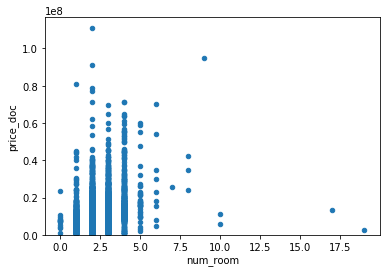

In [271]:
#var = train[train['build_year']]
#data = pd.concat([var, train['price_doc']], axis=0)
train.plot.scatter(x='num_room',y='price_doc', ylim=(10));


In [272]:
full_pivot = train.pivot_table(index='full_sq',
                                  values='price_doc', aggfunc=np.median)

In [273]:
full_pivot.head()

,price_doc
full_sq,
0,6296254.0
1,6465958.0
5,5770000.0
6,5177040.0
9,6300000.0


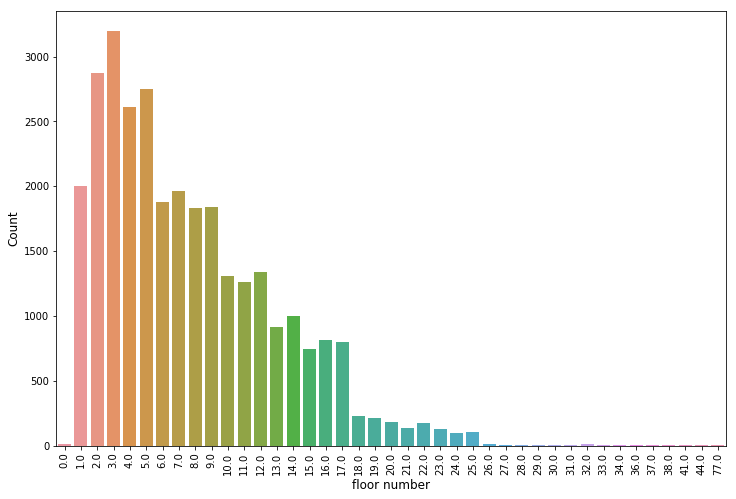

In [274]:
plt.figure(figsize=(12,8))
sns.countplot(x="floor", data=train)
plt.ylabel('Count', fontsize=12)
plt.xlabel('floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

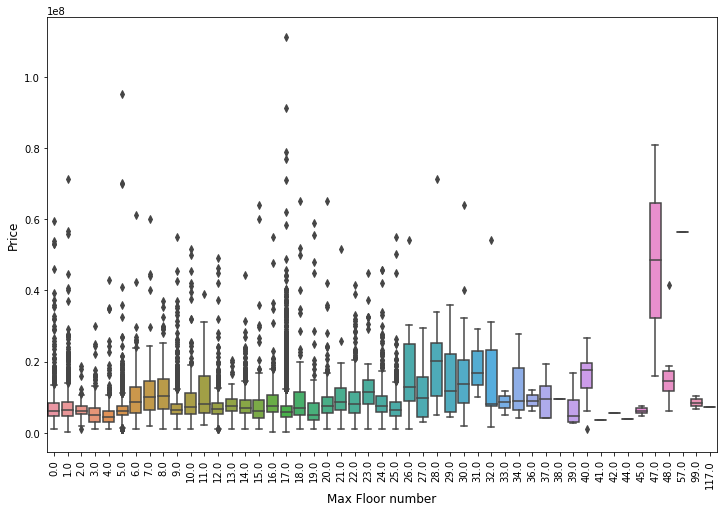

In [275]:
plt.figure(figsize=(12,8))
sns.boxplot(x="max_floor", y='price_doc', data=train)
plt.ylabel('Price', fontsize=12)
plt.xlabel('Max Floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

PCA

In [295]:
X_train = pd.get_dummies(X_train)

In [296]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=5, random_state=42)
regr.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [297]:
important_columns = pd.DataFrame([X_train.columns,regr.feature_importances_]).T.sort_values(1,ascending = False).head(70)
important_columns[0]

140                              full_sq
83                       cafe_count_3000
75                       cafe_count_2000
204                      office_sqm_5000
96            cafe_count_5000_price_2500
239                     sport_count_3000
261                               ttk_km
87            cafe_count_3000_price_2500
59                       cafe_count_1000
116          cafe_sum_5000_min_price_avg
86            cafe_count_3000_price_1500
120                          cemetery_km
244                                state
99            cafe_count_5000_price_high
50                            build_year
245                         swim_pool_km
260                                ts_km
273                   zd_vokzaly_avto_km
110          cafe_sum_1500_min_price_avg
77            cafe_count_2000_price_1000
39                build_count_after_1995
229                           sadovoe_km
46                  build_count_monolith
16                          ID_big_road2
20              

In [298]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=5, random_state=0)
regr.fit(X_train[important_columns[0]], Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [299]:
#X_train, X_test,Y_train, Y_test =train_test_split(train[train.columns[2:-1]],train[train.columns[-1]],test_size=0.33, random_state=42)

In [300]:
test_total = test.isnull().sum().sort_values(ascending=False)
test_percent = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
test_missing_data = pd.concat([test_total, test_percent], axis=1, keys=['Total', 'Percent'])
test_missing_data.head(20)

,Total,Percent
market_count_5000,0,0.0
build_count_brick,0,0.0
green_zone_km,0,0.0
industrial_km,0,0.0
water_treatment_km,0,0.0
cemetery_km,0,0.0
incineration_km,0,0.0
railroad_station_walk_km,0,0.0
railroad_station_walk_min,0,0.0
ID_railroad_station_walk,0,0.0


In [282]:
test= test.apply(lambda x:x.fillna(x.value_counts().index[0]))


In [284]:
X_test = test.drop(['timestamp','id'],axis =1)
X_test = pd.get_dummies(X_test)

In [198]:
Y_tag = regr.predict(X_test[important_columns[0]])

In [202]:
df_sub= pd.DataFrame(columns = ['price_doc'])
df_sub ['id'] = test.index.values
df_sub['price_doc'] = Y_tag

In [203]:
df_sub.to_csv('submission_data1.csv',index = False)

Linear

In [285]:
from sklearn import datasets, linear_model
lm = linear_model.LinearRegression()

In [286]:
# model = lm.fit(X_train, Y_train)
# predictions = lm.predict(X_test)
set(X_test.columns)-set(X_train.columns)

{'ecology_satisfactory'}